# 交互作用
ある入力変数の影響が他の入力変数によって左右される場合、モデル内に$x_1x_2$という入力変数を含めることで、この構造を表現でき、これを交互作用という。これに対して、個別の入力変数が与える影響を主効果という。交互作用項には、次の3つの種類がある。
1. カテゴリ変数×カテゴリ変数
2. カテゴリ変数×量的変数
3. 量的変数×量的変数

これらの交互作用についてモデル化し、係数の解釈の仕方を説明する。

## カテゴリ変数×カテゴリ変数
ここでは、宣伝の有無と安売りの有無とその交互作用が売り上げにどう影響を与えるかを線形モデルによってモデル化する。
モデルは次のように表される。
$$
\mu_i = w_0 + w_1x_{1i} + w_2x_{2i} + w_3x_{1i}x_{2i} \\
y_i \sim Normal(\mu_i, \sigma^2)
$$

### データの説明

In [50]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import pymc as pm

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [51]:
sales = pd.read_csv('../data/2-6-interaction-1.csv')

In [52]:
def f(x):
    label = "none"
    if (x.publicity=="to_implement") & (x.bargen=="not"):
        label = "publicity"
    elif (x.publicity=="not") & (x.bargen=="to_implement"):
        label = "bargen"
    elif (x.publicity=="to_implement") & (x.bargen=="to_implement"):
        label = "publicity and bargen"
    return label

sales['label'] = sales.apply(f, axis=1)

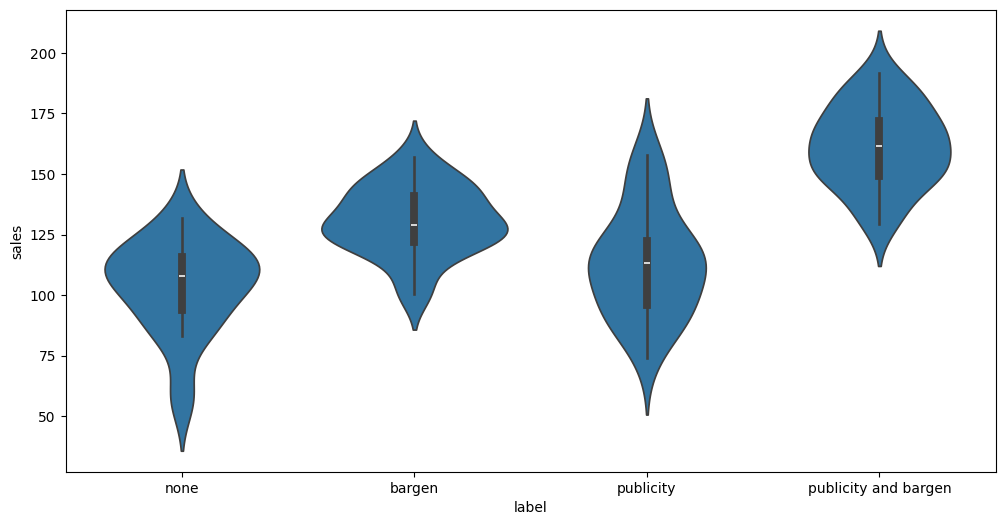

In [53]:
fig, axes = plt.subplots(1, 1, figsize=(12, 6), sharey=True)
sns.violinplot(x="label", y="sales", data=sales, ax=axes)
plt.show()

これを見ると、何も施策を打たないより、安売りや宣伝の施策を売った方が売上は上がり、それら二つを同時に打つことで相乗効果によってさらに売上が上がると思われる。これを交互作用を含めたモデルにすると次のようになる。
$$
\mu_i = w_0 + w_1x_{1i} +w_2x_{2i} + w_3x_{1i}x_{2i} \\
y_i \sim Normal(\mu_i, \sigma^2)
$$
ここで、$w_1, w_2$が主効果、$w_3$が交互作用である。

### pymcでの実装

In [54]:
y = sales.sales.values
publicity = (sales.publicity=="to_implement").astype(int)
bargain = (sales.bargen=="to_implement").astype(int)

In [55]:
linear_model = pm.Model()
with linear_model:
    # X, Yの観測値をConstantDataとして定義
    publicity_data = pm.ConstantData('publicity_data', publicity)
    bargain_data = pm.ConstantData('bargain_data', bargain)
    Y_data = pm.ConstantData('Y_data', y)

    # 確率変数w0, w1の定義(一次関数の傾きと切片)
    w0 = pm.Normal("w0", mu=0, sigma=20)
    w1 = pm.Normal("w1", mu=0, sigma=20)
    w2 = pm.Normal("w2", mu=0, sigma=20)
    w3 = pm.Normal("w3", mu=0, sigma=20)

    # 平均値muの計算
    mu = pm.Deterministic("mu", w0 + w1 * publicity_data + w2 * bargain_data + w3 * publicity_data * bargain_data)

    #　誤差を示す確率変数sigmaの定義
    sigma = pm.HalfCauchy("sigma", beta=10)

    # 観測値が従う確率分布の定義
    y_pred = pm.Normal('y_pred', mu=mu, sigma=sigma, observed=Y_data)

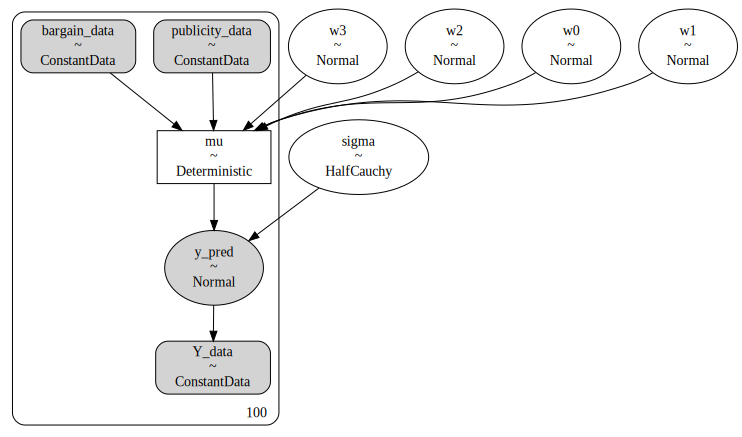

In [56]:
g = pm.model_to_graphviz(linear_model)
display(g)

In [57]:
with linear_model:
    trace = pm.sample(
        # 乱数系列の数(デフォルト2)
        chains=3,
        # 捨てるサンプル数(デフォルト1000)
        tune=2000,
        # 取得するサンプル数(デフォルト1000)
        draws=3000,
        random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [w0, w1, w2, w3, sigma]


Sampling 3 chains for 2_000 tune and 3_000 draw iterations (6_000 + 9_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w0,100.738,3.395,94.616,107.304,0.056,0.040,3647.0,5099.0,1.0
w1,12.750,4.799,3.818,21.615,0.078,0.056,3771.0,5342.0,1.0
w2,29.533,4.698,20.569,38.182,0.074,0.052,4048.0,5903.0,1.0
w3,17.711,6.726,5.287,30.322,0.109,0.077,3844.0,5354.0,1.0
sigma,18.328,1.332,15.993,20.910,0.017,0.012,6092.0,5159.0,1.0


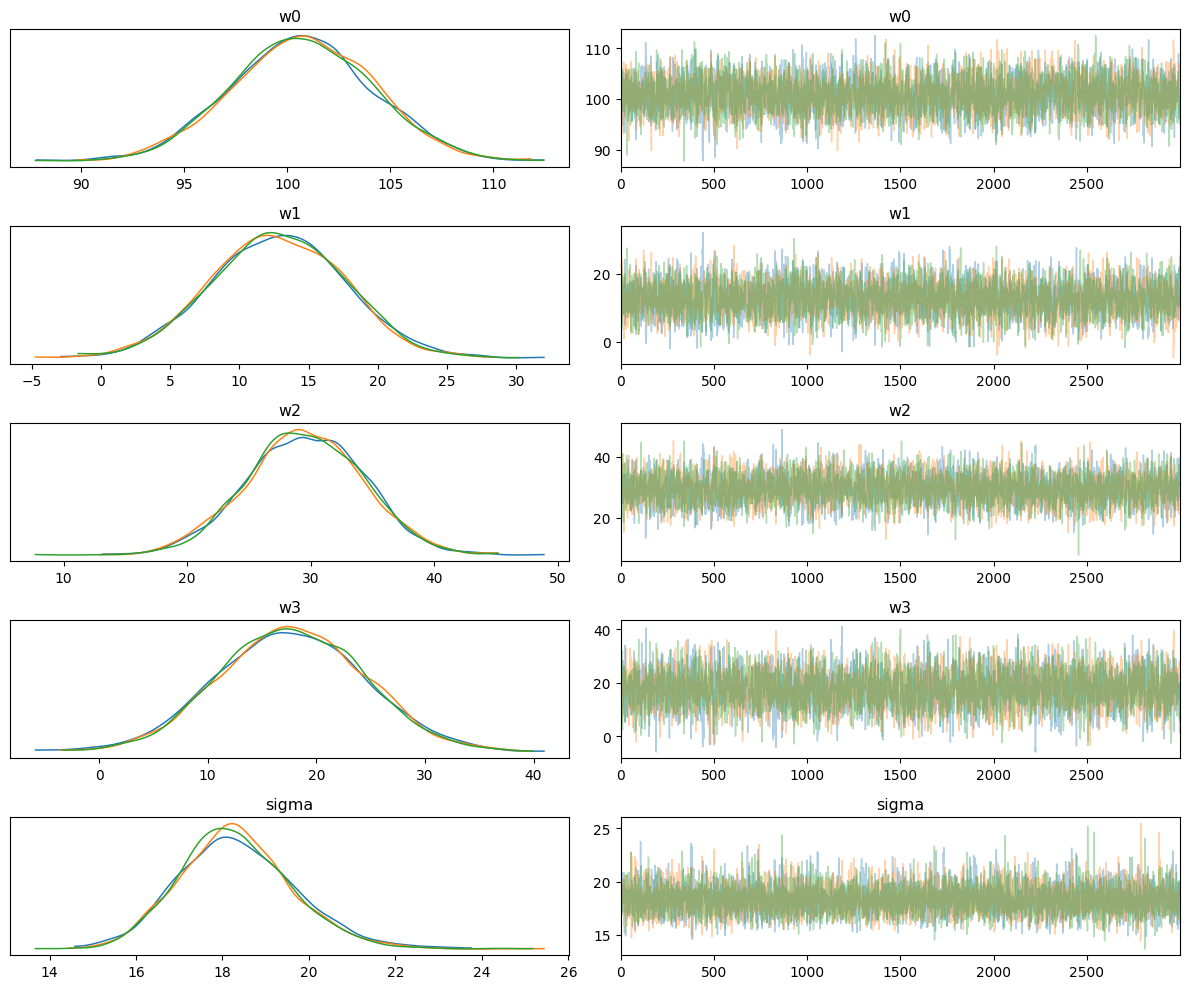

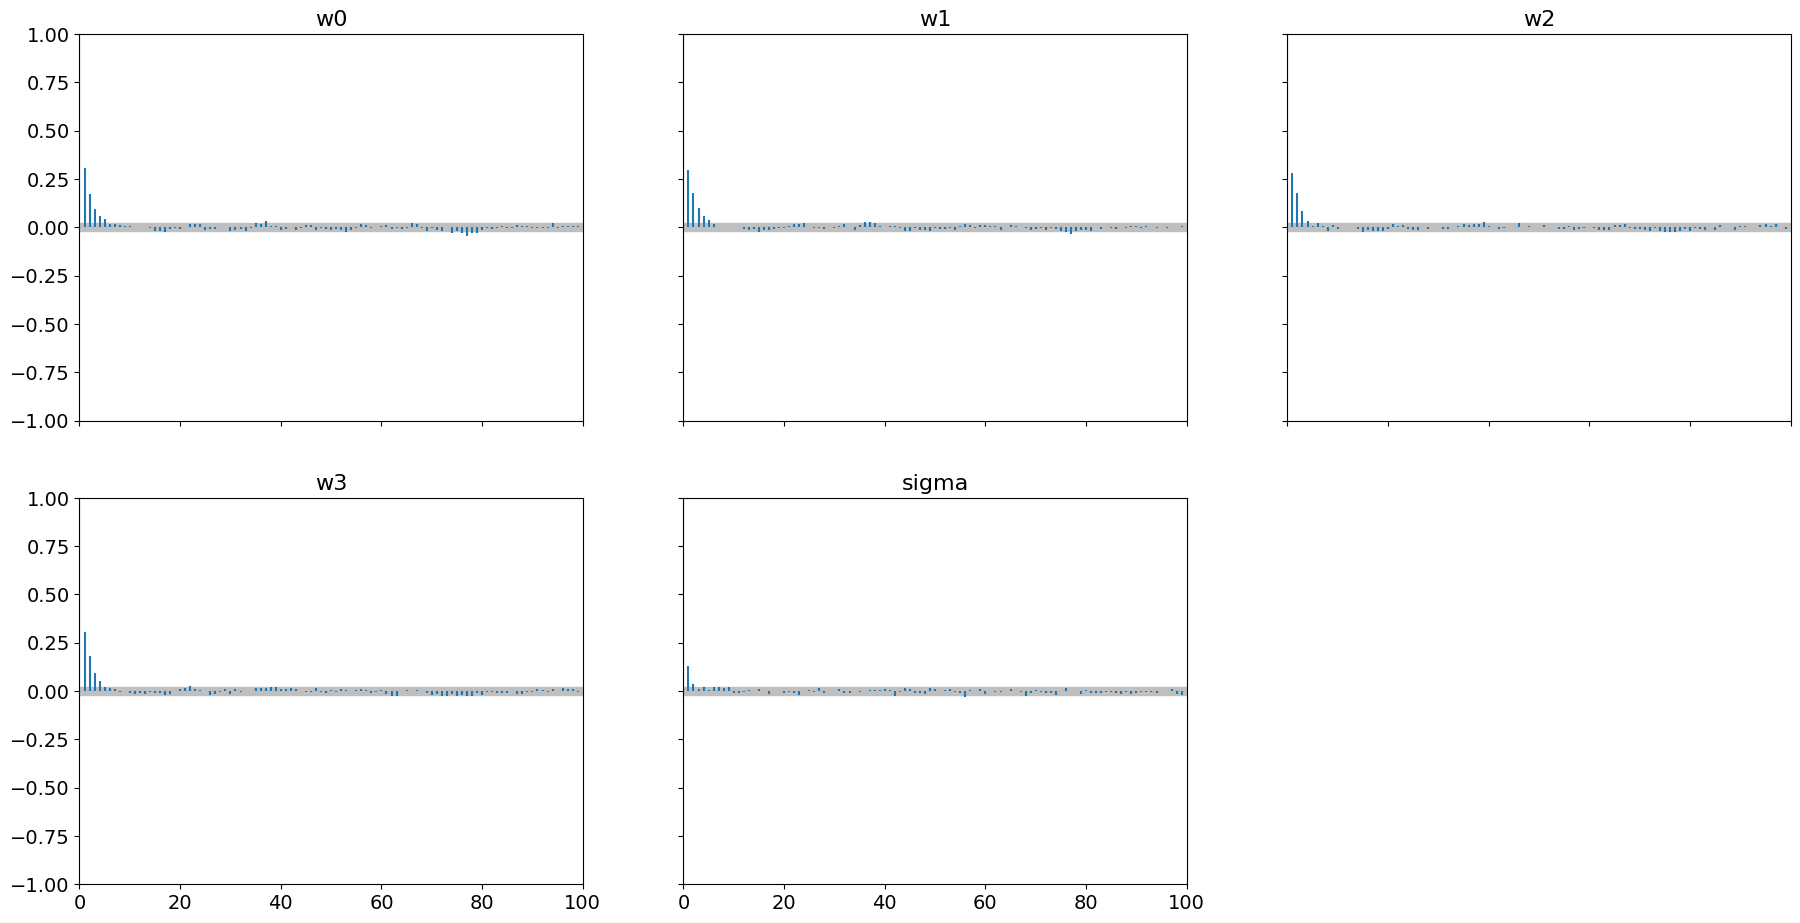

In [58]:
summary = az.summary(trace, var_names=["w0", "w1", "w2", "w3", "sigma"])
display(summary)

az.plot_trace(trace, var_names=["w0", "w1", "w2", "w3", "sigma"], compact=False)
plt.tight_layout()

az.plot_autocorr(trace, var_names=["w0", "w1", "w2", "w3", "sigma"], combined=True)
plt.show()

In [59]:
# summaryからmuの値を取得して、それぞれの組み合わせに対しての平均値とHPDを取得
mu_summary = az.summary(trace).iloc[5:]
mu_ = mu_summary[~mu_summary.duplicated()]

mu_mean = mu_["mean"].values
hdis = mu_[["hdi_3%", "hdi_97%"]].values

# エラーバーのために平均からの偏差を取得
err = np.abs(mu_.loc[:, ["hdi_3%", "hdi_97%"]].values-mu_mean.reshape(4,1))

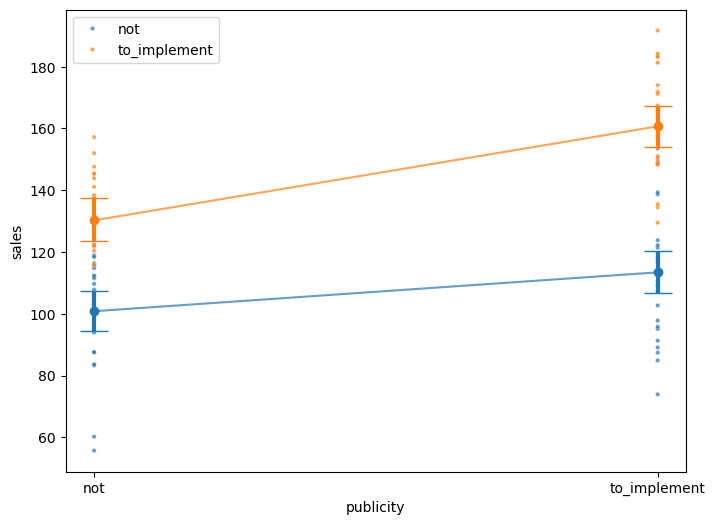

In [190]:
cmap = plt.get_cmap("tab10")
fig, axes = plt.subplots(1, 1, figsize=(8, 6), sharey=True)
# 施策ごとに色分けして散布図を描画
sns.scatterplot(sales, x=sales.publicity, y=sales.sales, hue=sales.bargen, s=10, alpha=0.7, ax=axes)

# それぞれの組み合わせに対して平均値とHPDをエラーバー付きで描画
axes.errorbar("not", mu_mean[0], yerr=err[0].reshape(2,1), fmt='o', color=cmap(0), ecolor=cmap(0), elinewidth=3, capsize=10)
axes.errorbar("not", mu_mean[1], yerr=err[1].reshape(2,1), fmt='o', color=cmap(1), ecolor=cmap(1), elinewidth=3, capsize=10)
axes.errorbar("to_implement", mu_mean[2], yerr=err[2].reshape(2,1), fmt='o', color=cmap(0), ecolor=cmap(0), elinewidth=3, capsize=10)
axes.errorbar("to_implement", mu_mean[3], yerr=err[3].reshape(2,1), fmt='o', color=cmap(1), ecolor=cmap(1), elinewidth=3, capsize=10)

# それぞれの組み合わせに対して平均値を線で結んで描画
axes.plot(["not", "to_implement"], mu_mean[[0,2]], color=cmap(0), alpha=0.7)
axes.plot(["not", "to_implement"], mu_mean[[1,3]], color=cmap(1), alpha=0.7)
plt.legend()
plt.show()

これを見ると、交互作用があることによって二つの施策を同時に行った際に売上が大きく伸びることがわかる。

### pystanでの実装

In [62]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import stan
import nest_asyncio
nest_asyncio.apply()

In [63]:
sales = pd.read_csv('../data/2-6-interaction-1.csv')

In [64]:
sales

,sales,publicity,bargen
0,87.5,not,not
1,103.7,not,not
2,83.3,not,not
3,131.9,not,not
4,106.6,not,not
...,...,...,...
95,171.2,to_implement,to_implement
96,134.5,to_implement,to_implement
97,148.5,to_implement,to_implement
98,135.5,to_implement,to_implement


In [65]:
y = sales.sales.values
publicity = (sales.publicity=="to_implement").astype(int)
bargain = (sales.bargen=="to_implement").astype(int)
interaction = publicity * bargain
X = np.vstack([np.ones(len(y)), publicity, bargain, interaction]).T

In [66]:
publicity_pred = np.array([0]*50 + [1]*50 + [0]*50 + [1]*50)
bargain_pred = np.array([0]*50 + [0]*50 + [1]*50 + [1]*50)
interaction_pred = publicity_pred * bargain_pred
X_pred = np.vstack([np.ones(200), publicity_pred, bargain_pred, interaction_pred]).T

In [67]:
stan_data = {
    "N": len(y),
    "K": X.shape[1],
    "y": y,
    "X": X, 
    "N_pred": X_pred.shape[0],
    "X_pred": X_pred
}

In [68]:
with open('../stan/2-6-interaction.stan') as f:
    stan_code = f.read()

In [69]:
sm = stan.build(stan_code, data=stan_data, random_seed=123)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [70]:
fit = sm.sample(num_chains=3, num_samples=6000, num_warmup=1000, num_thin=2)

Sampling:   0%
Sampling:  33% (7000/21000)
Sampling:  67% (14000/21000)
Sampling: 100% (21000/21000)
Sampling: 100% (21000/21000), done.
Messages received during sampling:
  Gradient evaluation took 0.000114 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.14 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.5 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.45 seconds.
  Adjust your expectations accordingly!


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],103.402,3.681,96.621,110.333,0.047,0.033,6226.0,7321.0,1.0
beta[1],9.851,5.244,0.398,20.180,0.068,0.048,5876.0,7218.0,1.0
beta[2],27.287,5.211,17.824,37.458,0.065,0.046,6516.0,6953.0,1.0
beta[3],20.811,7.339,6.661,34.028,0.096,0.068,5847.0,7185.0,1.0
sigma,18.452,1.328,16.068,21.005,0.015,0.011,8061.0,7647.0,1.0


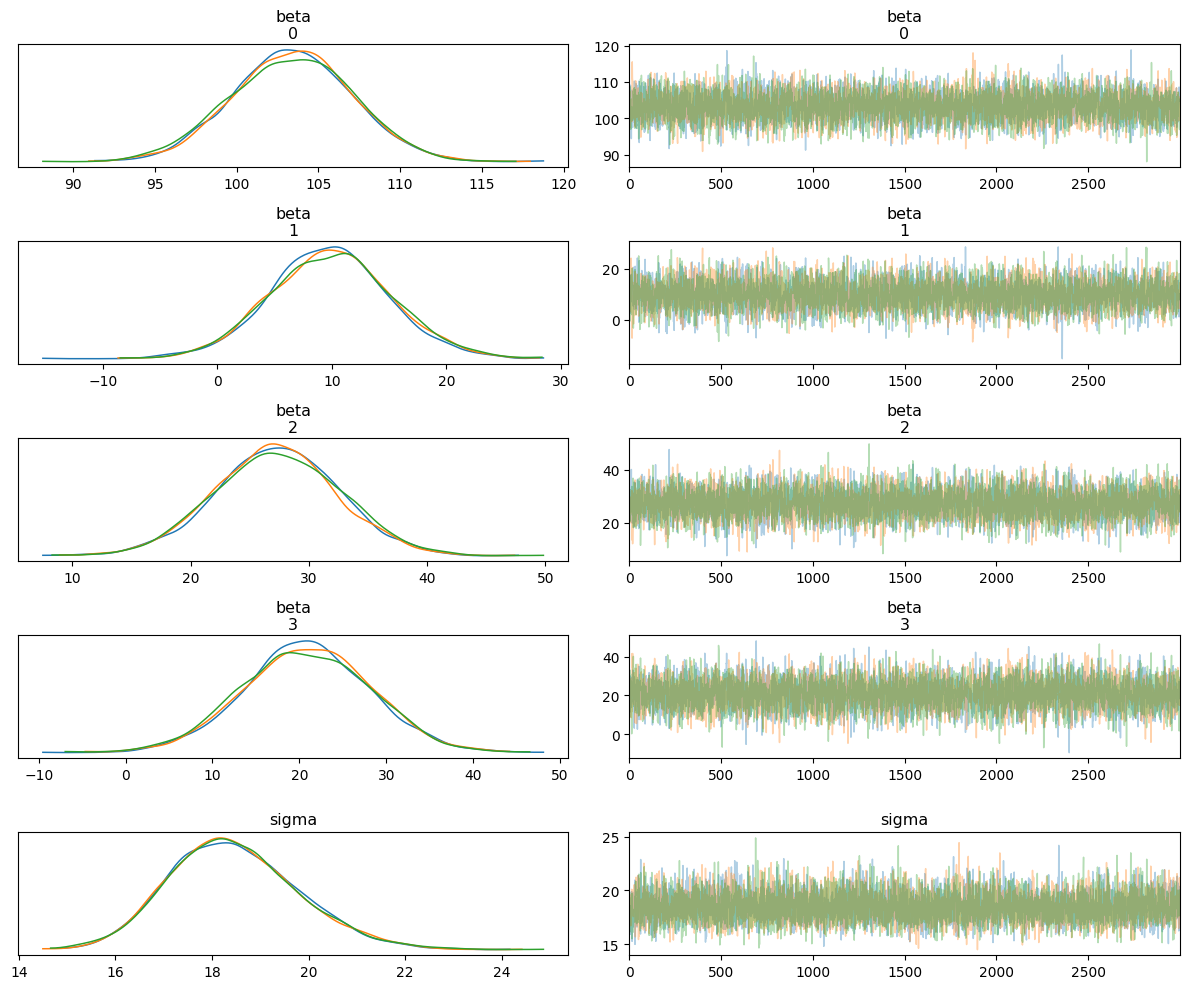

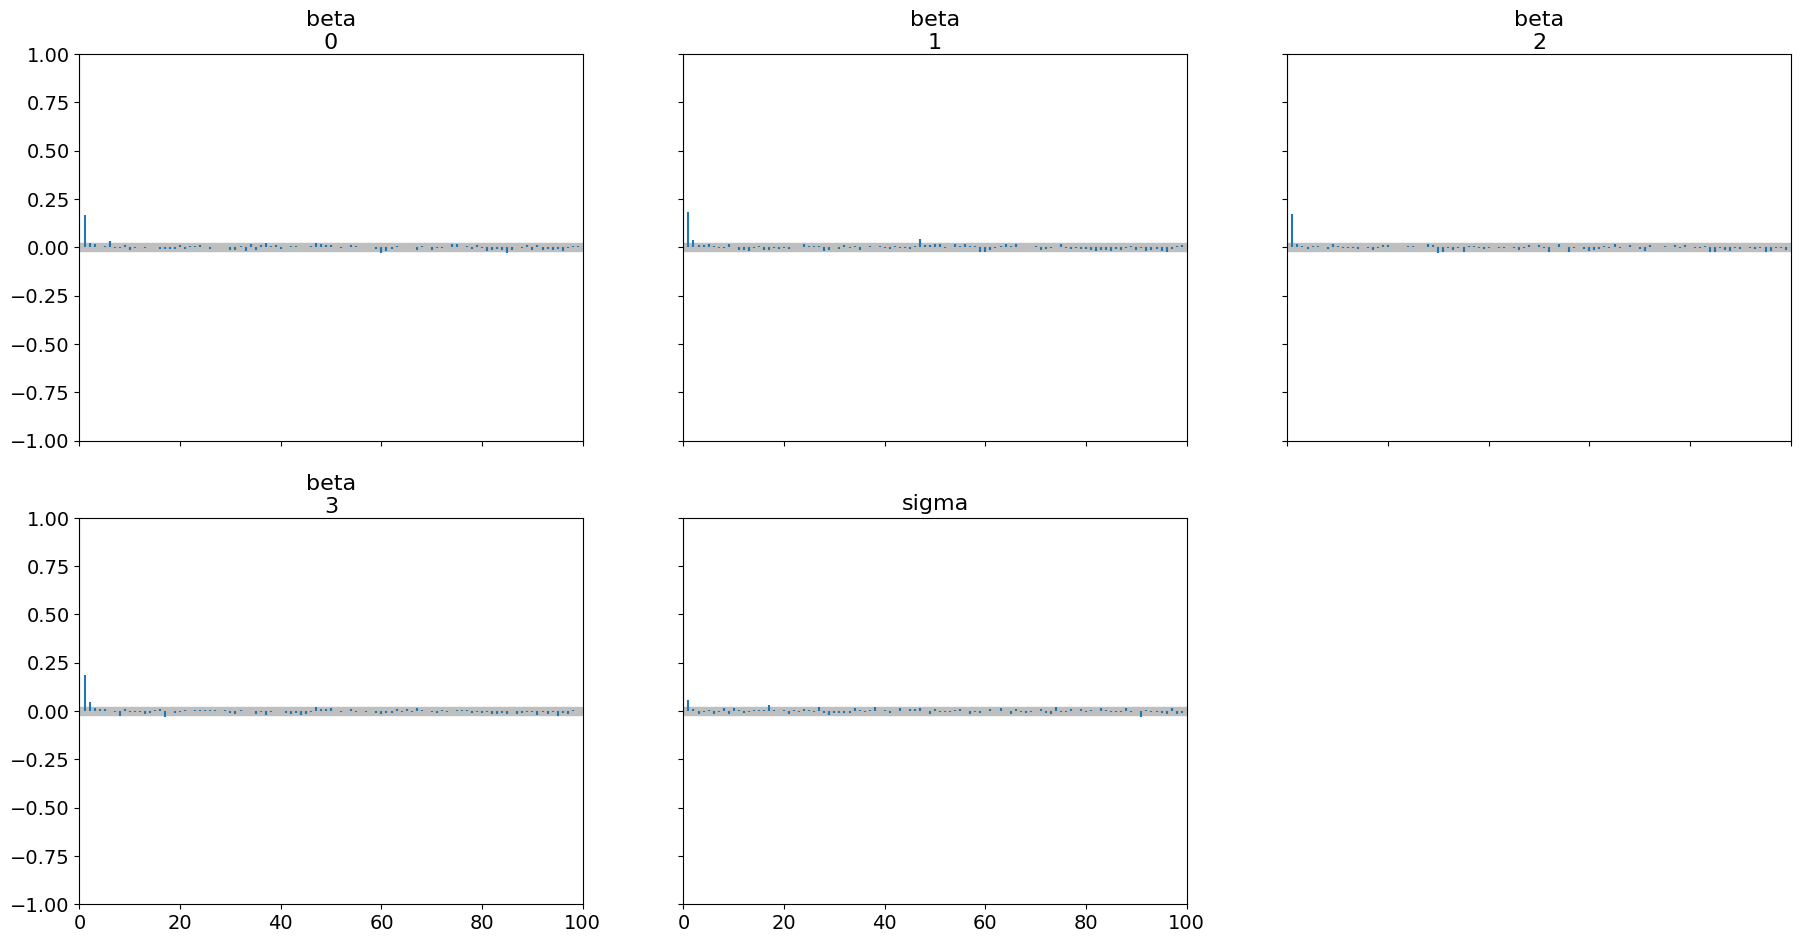

In [71]:
summary = az.summary(fit, var_names=["beta", "sigma"])
display(summary)

az.plot_trace(fit, var_names=["beta", "sigma"], compact=False)
plt.tight_layout()

az.plot_autocorr(fit, var_names=["beta", "sigma"], combined=True)
plt.show()

In [75]:
# summaryからmuの値を取得して、それぞれの組み合わせに対しての平均値とHPDを取得
mu_summary = az.summary(fit, var_names=["mu"])
mu_ = mu_summary[~mu_summary.duplicated()]

mu_mean = mu_["mean"].values
hdis = mu_[["hdi_3%", "hdi_97%"]].values

# エラーバーのために平均からの偏差を取得
err = np.abs(mu_.loc[:, ["hdi_3%", "hdi_97%"]].values - mu_mean.reshape(4,1))

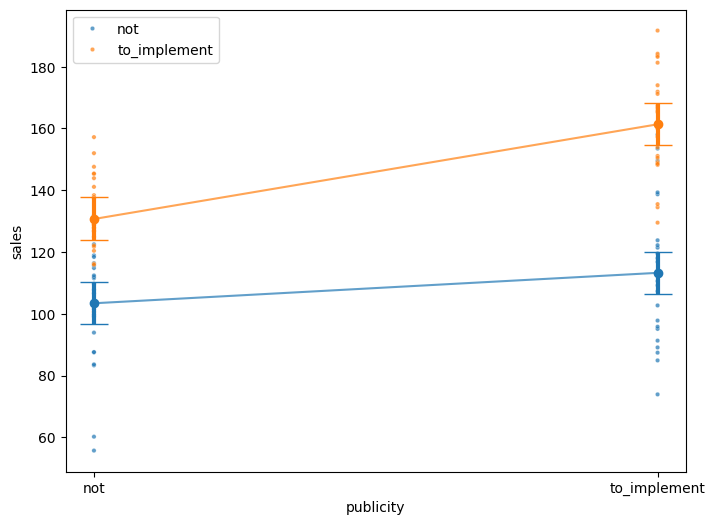

In [76]:
cmap = plt.get_cmap("tab10")
fig, axes = plt.subplots(1, 1, figsize=(8, 6), sharey=True)
# 施策ごとに色分けして散布図を描画
sns.scatterplot(sales, x=sales.publicity, y=sales.sales, hue=sales.bargen, s=10, alpha=0.7, ax=axes)

# それぞれの組み合わせに対して平均値とHPDをエラーバー付きで描画
axes.errorbar("not", mu_mean[0], yerr=err[0].reshape(2,1), fmt='o', color=cmap(0), ecolor=cmap(0), elinewidth=3, capsize=10)
axes.errorbar("not", mu_mean[1], yerr=err[1].reshape(2,1), fmt='o', color=cmap(1), ecolor=cmap(1), elinewidth=3, capsize=10)
axes.errorbar("to_implement", mu_mean[2], yerr=err[2].reshape(2,1), fmt='o', color=cmap(0), ecolor=cmap(0), elinewidth=3, capsize=10)
axes.errorbar("to_implement", mu_mean[3], yerr=err[3].reshape(2,1), fmt='o', color=cmap(1), ecolor=cmap(1), elinewidth=3, capsize=10)

# それぞれの組み合わせに対して平均値を線で結んで描画
axes.plot(["not", "to_implement"], mu_mean[[0,2]], color=cmap(0), alpha=0.7)
axes.plot(["not", "to_implement"], mu_mean[[1,3]], color=cmap(1), alpha=0.7)
plt.legend()
plt.show()

### 事後分布の解釈
各回帰係数の期待値は$w_0=100.8,\ w_1=12.58,\ w_2=29.42,\ w_3=17.85$となる。このことから、何も施策を打たなければ売上は100万程度であるが、宣伝施策と安売り施策を独立に打つことで12.58万、29.42万売上が伸びることがわかる。さらに、両者の施策を同時に打つことで交互作用の影響で売り上げが18万ほど伸びる。

## カテゴリ変数×量的変数
今度はカテゴリ変数と連続変数の交互作用を考える。ここでは宣伝の有無と気温から売上を回帰するモデルを考える。

### データの説明

In [77]:
sales = pd.read_csv('../data/2-6-interaction-2.csv')

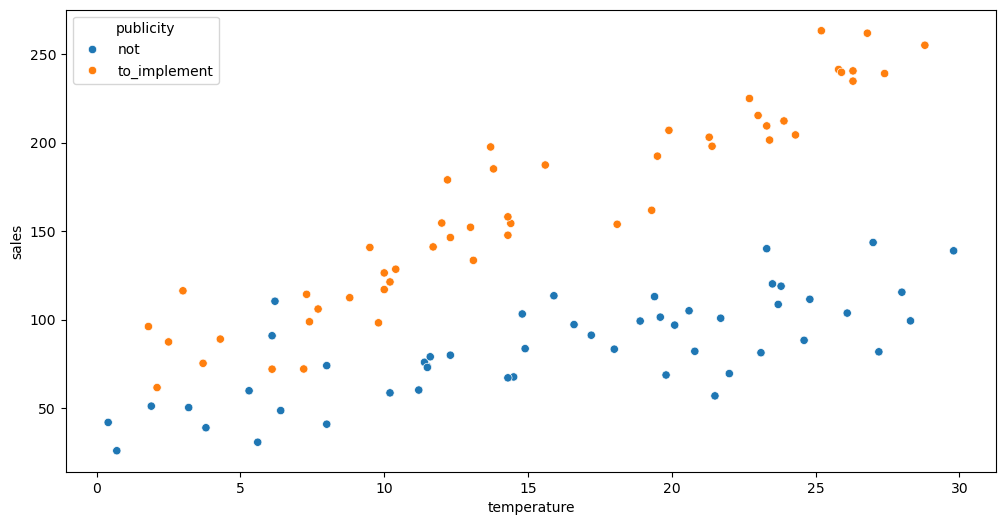

In [203]:
fig, axes = plt.subplots(1, 1, figsize=(12, 6), sharey=True)
sns.scatterplot(x="temperature", y="sales", data=sales, hue="publicity", ax=axes)
plt.show()

宣伝を行うことで気温の傾きが増加しているように見える。

### pymcでの実装

In [193]:
y = sales.sales.values
publicity = (sales.publicity=="to_implement").astype(int)
temp = sales.temperature.values

In [194]:
linear_model = pm.Model()
with linear_model:
    # X, Yの観測値をConstantDataとして定義
    publicity_data = pm.ConstantData('publicity_data', publicity)
    temp_data = pm.ConstantData('temp_data', temp)
    Y_data = pm.ConstantData('Y_data', y)

    # 確率変数w0, w1の定義(一次関数の傾きと切片)
    w0 = pm.Normal("w0", mu=0, sigma=20)
    w1 = pm.Normal("w1", mu=0, sigma=20)
    w2 = pm.Normal("w2", mu=0, sigma=20)
    w3 = pm.Normal("w3", mu=0, sigma=20)

    # 平均値muの計算
    mu = pm.Deterministic("mu", w0 + w1 * publicity_data + w2 * temp_data + w3 * publicity_data * temp_data)

    #　誤差を示す確率変数sigmaの定義
    sigma = pm.HalfCauchy("sigma", beta=10)

    # 観測値が従う確率分布の定義
    y_pred = pm.Normal('y_pred', mu=mu, sigma=sigma, observed=Y_data)

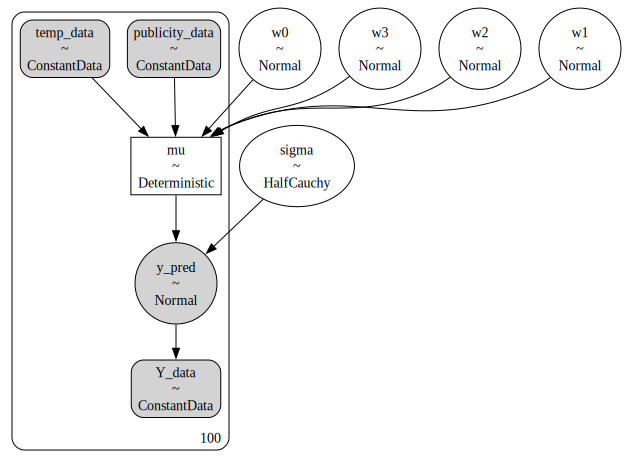

In [195]:
g = pm.model_to_graphviz(linear_model)
display(g)

In [196]:
with linear_model:
    trace = pm.sample(
        # 乱数系列の数(デフォルト2)
        chains=3,
        # 捨てるサンプル数(デフォルト1000)
        tune=2000,
        # 取得するサンプル数(デフォルト1000)
        draws=3000,
        random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [w0, w1, w2, w3, sigma]


Sampling 3 chains for 2_000 tune and 3_000 draw iterations (6_000 + 9_000 draws total) took 6 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w0,41.012,5.477,30.832,51.472,0.095,0.067,3328.0,4715.0,1.0
w1,17.923,7.395,4.538,32.332,0.123,0.087,3614.0,4413.0,1.0
w2,2.683,0.307,2.134,3.288,0.005,0.004,3498.0,4675.0,1.0
w3,4.168,0.428,3.371,4.976,0.007,0.005,3641.0,4611.0,1.0
sigma,18.603,1.365,16.122,21.221,0.020,0.014,4845.0,4411.0,1.0


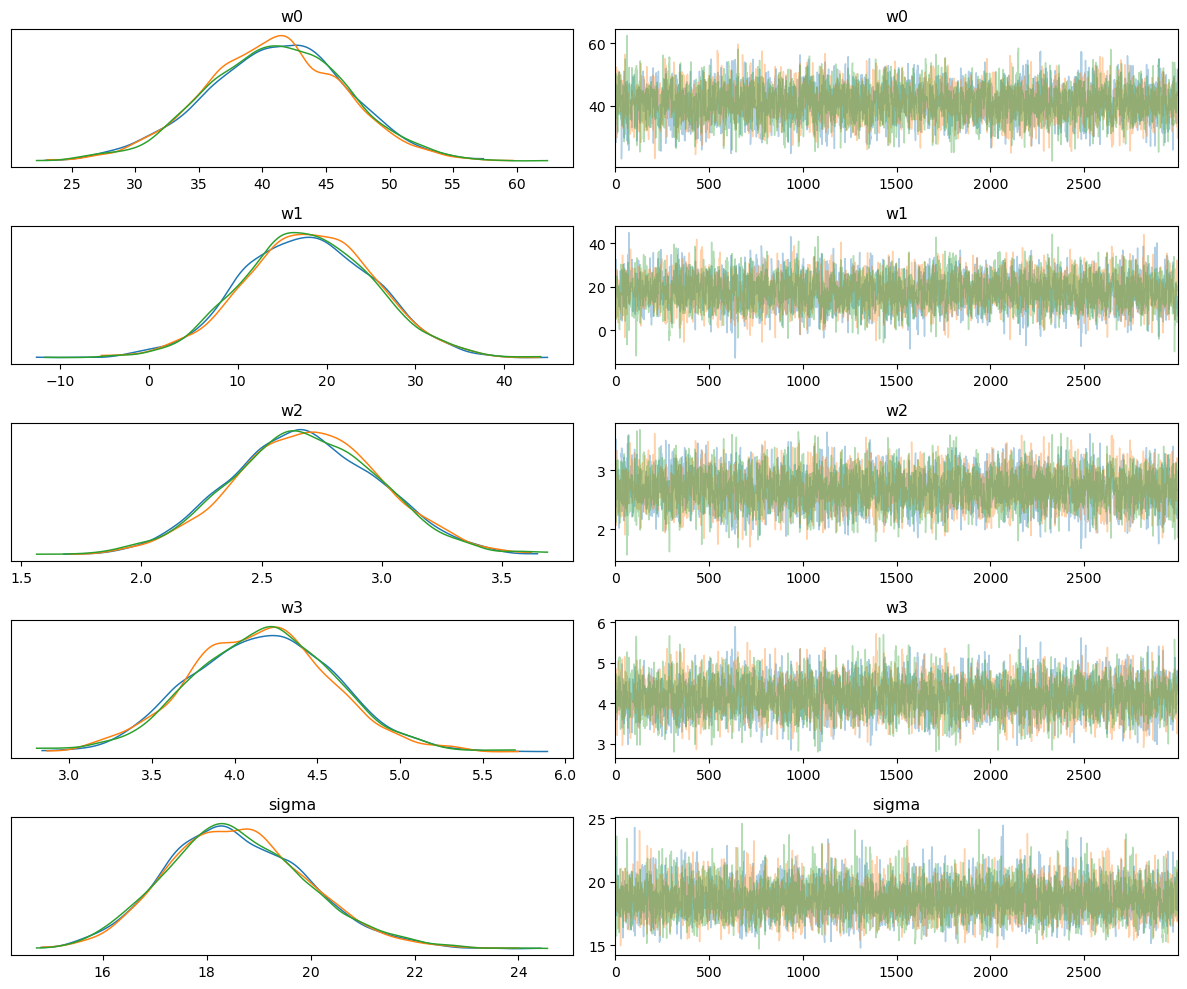

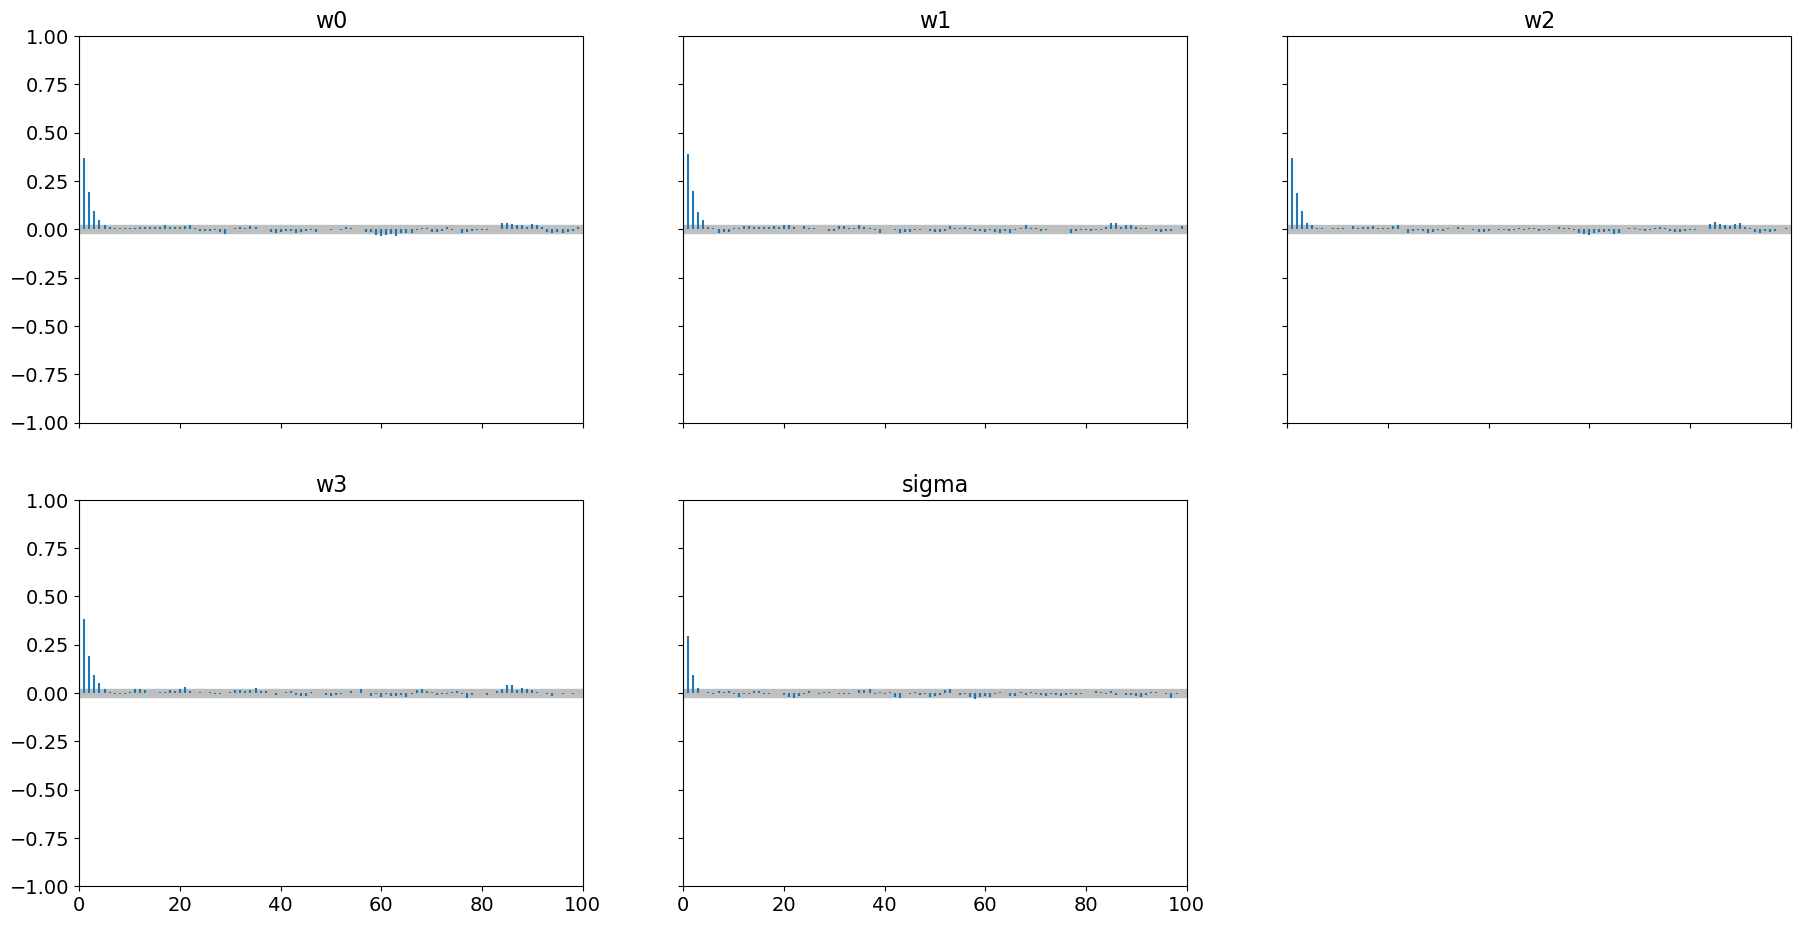

In [197]:
summary = az.summary(trace, var_names=["w0", "w1", "w2", "w3", "sigma"])
display(summary)

az.plot_trace(trace, var_names=["w0", "w1", "w2", "w3", "sigma"], compact=False)
plt.tight_layout()

az.plot_autocorr(trace, var_names=["w0", "w1", "w2", "w3", "sigma"], combined=True)
plt.show()

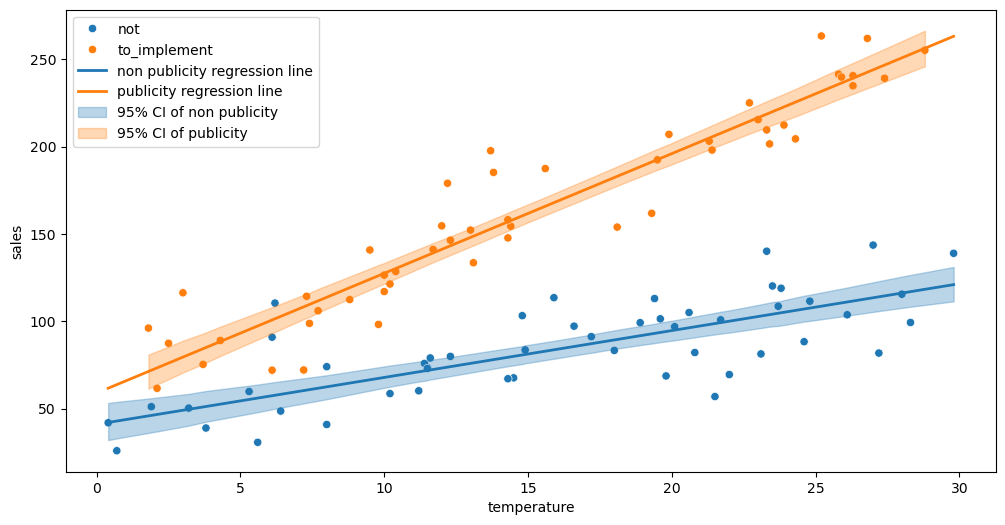

In [213]:
temp_values = np.array([temp.min(), temp.max()])
cmap = plt.get_cmap("tab10")

# 平均回帰直線の計算
w0_mean = summary['mean'].w0
w1_mean = summary['mean'].w1
w2_mean = summary['mean'].w2
w3_mean = summary['mean'].w3
publicity_mean = w0_mean + w1_mean + (w2_mean + w3_mean) * temp_values
non_mean = w0_mean + w2_mean * temp_values

# 各天気の気温データ
publicity_temp = sales.temperature[sales.publicity=="to_implement"].values
non_temp = sales.temperature[~(sales.publicity=="to_implement")].values

#　各天気の気温データの昇順インデックス
idx_publicity = np.argsort(publicity_temp)
idx_non = np.argsort(non_temp)

# 各天気の95% HDIの計算
hdis = az.hdi(trace.posterior, hdi_prob=0.95)["mu"].values
hdi_publicity = hdis[sales.publicity=="to_implement"][idx_publicity]
hdi_non = hdis[~(sales.publicity=="to_implement")][idx_non]


fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
sns.scatterplot(x='temperature', y='sales', data=sales, hue="publicity", ax=axes)    # 観測値の散布図

#各天気の回帰直線
axes.plot(temp_values, non_mean, lw=2, c=cmap(0), label='non publicity regression line')
axes.plot(temp_values, publicity_mean, lw=2, c=cmap(1), label='publicity regression line')

# 各天気の95% HDI
axes.fill_between(non_temp[idx_non], y1=hdi_non[:,0], y2=hdi_non[:,1], color=cmap(0), alpha=0.30, label="95% HDI of non publicity")
axes.fill_between(publicity_temp[idx_publicity], y1=hdi_publicity[:,0], y2=hdi_publicity[:,1], color=cmap(1), alpha=0.30, label="95% HDI of publicity")
plt.legend()
plt.show()

このように切片だけでなく傾きも大きくなっていることがわかる。

### pystanでの実装

In [78]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import stan
import nest_asyncio
nest_asyncio.apply()

In [79]:
sales = pd.read_csv('../data/2-6-interaction-2.csv')

In [80]:
sales

,sales,publicity,temperature
0,74.0,not,8.0
1,60.2,not,11.2
2,91.2,not,17.2
3,81.8,not,27.2
4,90.9,not,6.1
...,...,...,...
95,212.3,to_implement,23.9
96,197.6,to_implement,13.7
97,146.4,to_implement,12.3
98,204.4,to_implement,24.3


In [81]:
y = sales.sales.values
publicity = (sales.publicity=="to_implement").astype(int)
temp = sales.temperature.values
interaction = publicity * temp
X = np.vstack([np.ones(len(y)), publicity, temp, interaction]).T

In [82]:
temp_pred = np.tile(np.linspace(temp.min(), temp.max(), 100), 2)
publicity_pred = np.array([0]*100 + [1]*100)
interaction_pred = temp_pred * publicity_pred
X_pred = np.vstack([np.ones(200), publicity_pred, temp_pred, interaction_pred]).T
N_pred = 200

In [84]:
stan_data = {
    "N": len(y),
    "K": X.shape[1],
    "y": y,
    "X": X,
    "N_pred": N_pred,
    "X_pred": X_pred
}

In [85]:
with open('../stan/2-6-interaction.stan') as f:
    stan_code = f.read()

In [86]:
sm = stan.build(stan_code, data=stan_data, random_seed=123)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [87]:
fit = sm.sample(num_chains=3, num_samples=6000, num_warmup=1000, num_thin=2)

Sampling:   0%
Sampling:  33% (7000/21000)
Sampling:  67% (14000/21000)
Sampling: 100% (21000/21000)
Sampling: 100% (21000/21000), done.
Messages received during sampling:
  Gradient evaluation took 0.000118 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.18 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.21 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.46 seconds.
  Adjust your expectations accordingly!


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],43.049,5.823,32.151,54.074,0.083,0.059,4954.0,6323.0,1.0
beta[1],17.248,8.212,1.962,33.011,0.118,0.084,4828.0,6361.0,1.0
beta[2],2.580,0.327,1.954,3.182,0.005,0.003,5024.0,6273.0,1.0
beta[3],4.200,0.472,3.303,5.082,0.007,0.005,4819.0,5814.0,1.0
sigma,18.790,1.383,16.294,21.395,0.016,0.011,7346.0,7434.0,1.0


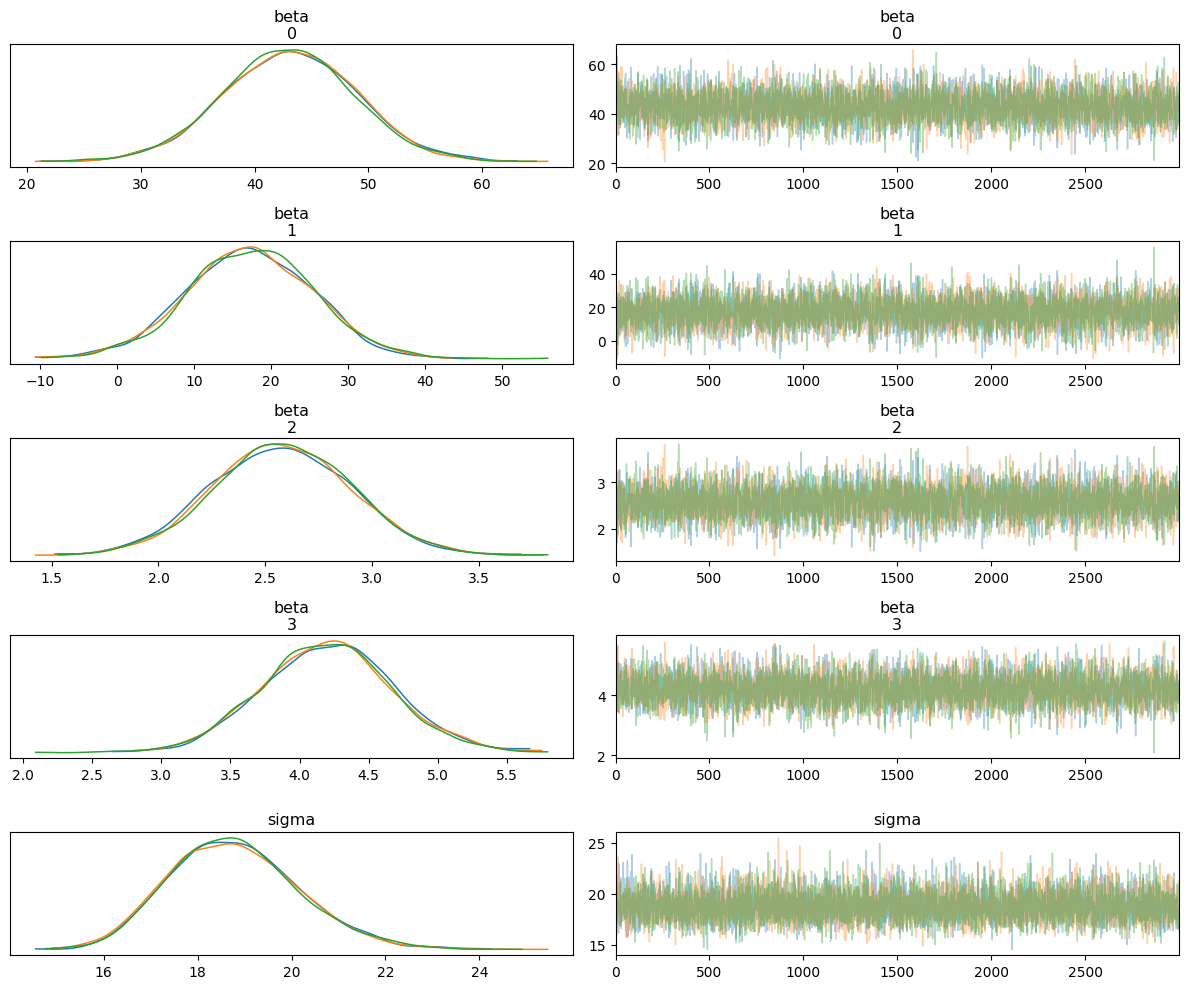

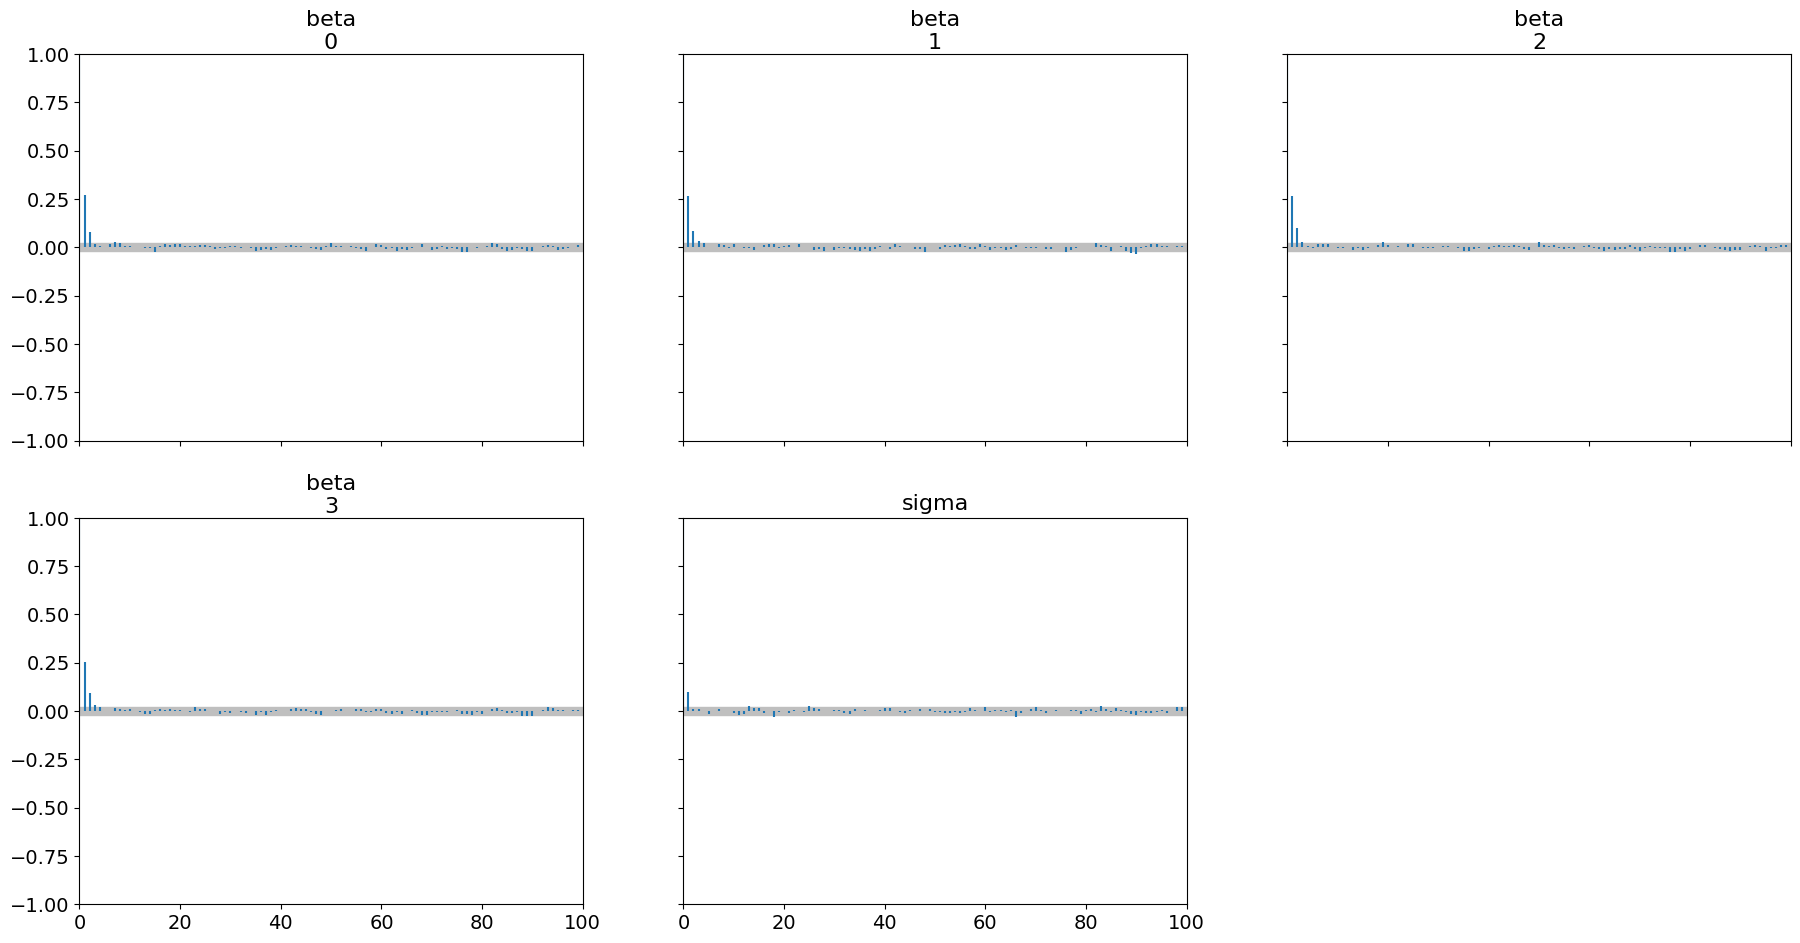

In [90]:
summary = az.summary(fit, var_names=["beta", "sigma"])
display(summary)

az.plot_trace(fit, var_names=["beta", "sigma"], compact=False)
plt.tight_layout()

az.plot_autocorr(fit, var_names=["beta", "sigma"], combined=True)
plt.show()

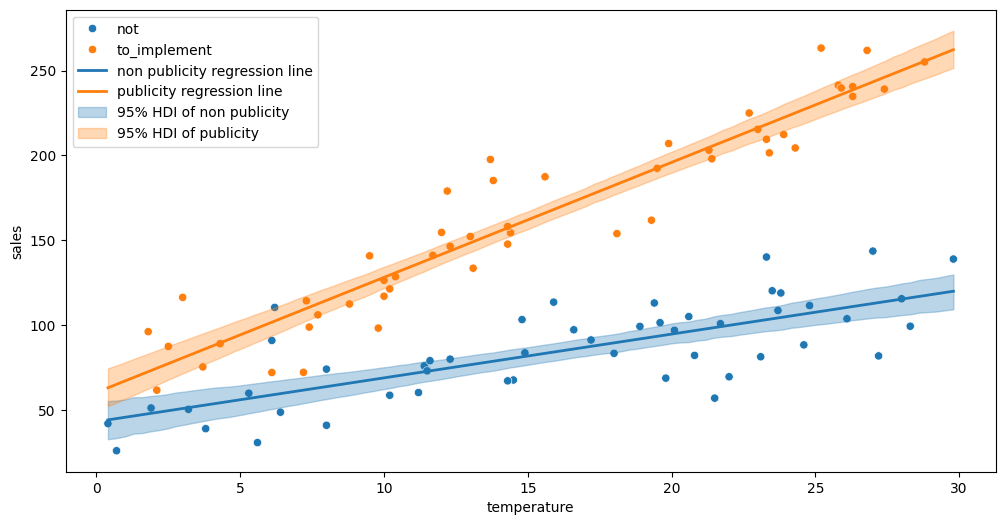

In [104]:
cmap = plt.get_cmap("tab10")
non_idx = X_pred[:,1]==0
publicity_idx = X_pred[:,1]==1
non_temp = X_pred[non_idx][:,2]
publicity_temp = X_pred[publicity_idx][:,2]

# 平均回帰直線の計算
beta_mean = az.summary(fit, var_names=["beta"])["mean"].values
means = np.dot(X_pred, beta_mean)
non_mean = means[non_idx]
publicity_mean = means[publicity_idx]

# 各天気の95% HDIの計算
hdis = az.hdi(fit, hdi_prob=0.95)["mu_pred"].values
hdi_publicity = hdis[publicity_idx]
hdi_non = hdis[non_idx]


fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
sns.scatterplot(x='temperature', y='sales', data=sales, hue="publicity", ax=axes)    # 観測値の散布図

#各天気の回帰直線
axes.plot(non_temp, non_mean, lw=2, c=cmap(0), label='non publicity regression line')
axes.plot(publicity_temp, publicity_mean, lw=2, c=cmap(1), label='publicity regression line')

# 各天気の95% HDI
axes.fill_between(non_temp, y1=hdi_non[:,0], y2=hdi_non[:,1], color=cmap(0), alpha=0.30, label="95% HDI of non publicity")
axes.fill_between(publicity_temp, y1=hdi_publicity[:,0], y2=hdi_publicity[:,1], color=cmap(1), alpha=0.30, label="95% HDI of publicity")
plt.legend()
plt.show()

### 係数の解釈
モデルは次のようになっている。
$$
\mu_i = w_0 + w_1x_{1i} + w_2x_{2i} + w_3x_{1i}x_{2i} \\
y_i \sim Normal(\mu_i, \sigma^2)
$$
ここで気温$x_{2i}$でまとめると$\mu_i$は次のようになる。
$$
\mu_i = w_0 + w_1x_{1i} + (w_2 + w_3x_{1i})x_{2i}
$$
よって、宣伝を行うことで宣伝の主効果によって切片が変化し、宣伝と気温の交互作用によって気温の傾きが変化する。

$w_0,\ w_1,\ w_2,\ w_3$の期待値はそれぞれ41.0, 17.9, 2.6, 4.1であるので、宣伝を行うことで切片は17.9増加し、気温の変化に対する傾きは4.1増加する。

## 量的変数×量的変数
次に、量的変数同士の交互作用をモデル化する。ここでは、販売している製品の種類数と店員の数から売上を回帰するモデルを考える。

### データの説明

In [214]:
sales = pd.read_csv('../data/2-6-interaction-3.csv')

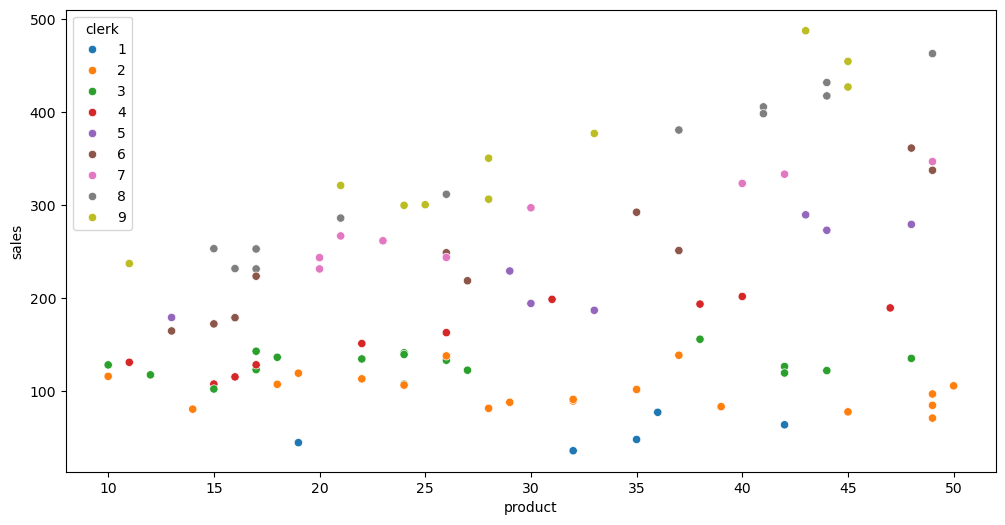

In [221]:
fig, axes = plt.subplots(1, 1, figsize=(12, 6), sharey=True)
sns.scatterplot(x="product", y="sales", data=sales, hue="clerk", ax=axes, palette="tab10")
plt.show()

少し読み取りづらいが、店員が多い時に商品数を増やせば売上が増えそうである。今回は店員数が離散変数なので色分けしてプロットできたが、連続変数の時は難しいのでビニングしてみたり別の可視化を選ぶべきである。

### pymcでの実装

In [226]:
y = sales.sales.values
product = sales["product"].values
clerk = sales.clerk.values

In [227]:
linear_model = pm.Model()
with linear_model:
    # X, Yの観測値をConstantDataとして定義
    clerk_data = pm.ConstantData('clerk_data', clerk)
    product_data = pm.ConstantData('product_data', product)
    Y_data = pm.ConstantData('Y_data', y)

    # 確率変数w0, w1の定義(一次関数の傾きと切片)
    w0 = pm.Normal("w0", mu=0, sigma=20)
    w1 = pm.Normal("w1", mu=0, sigma=20)
    w2 = pm.Normal("w2", mu=0, sigma=20)
    w3 = pm.Normal("w3", mu=0, sigma=20)

    # 平均値muの計算
    mu = pm.Deterministic("mu", w0 + w1 * clerk_data + w2 * product_data + w3 * clerk_data * product_data)

    #　誤差を示す確率変数sigmaの定義
    sigma = pm.HalfCauchy("sigma", beta=10)

    # 観測値が従う確率分布の定義
    y_pred = pm.Normal('y_pred', mu=mu, sigma=sigma, observed=Y_data)

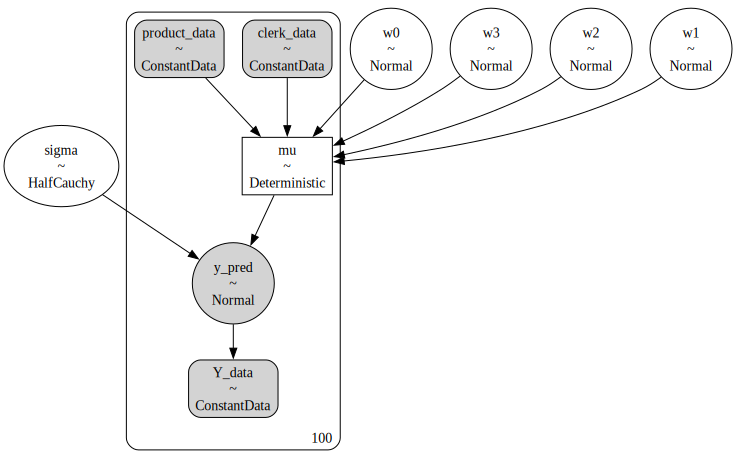

In [228]:
g = pm.model_to_graphviz(linear_model)
display(g)

In [229]:
with linear_model:
    trace = pm.sample(
        # 乱数系列の数(デフォルト2)
        chains=3,
        # 捨てるサンプル数(デフォルト1000)
        tune=2000,
        # 取得するサンプル数(デフォルト1000)
        draws=3000,
        random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [w0, w1, w2, w3, sigma]


Sampling 3 chains for 2_000 tune and 3_000 draw iterations (6_000 + 9_000 draws total) took 9 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w0,64.556,10.958,44.137,85.108,0.229,0.162,2298.0,2680.0,1.0
w1,10.343,2.074,6.284,14.148,0.044,0.031,2213.0,2876.0,1.0
w2,-1.577,0.345,-2.198,-0.903,0.007,0.005,2255.0,2977.0,1.0
w3,0.940,0.065,0.816,1.061,0.001,0.001,2172.0,2950.0,1.0
sigma,20.424,1.544,17.669,23.342,0.025,0.018,3849.0,4209.0,1.0


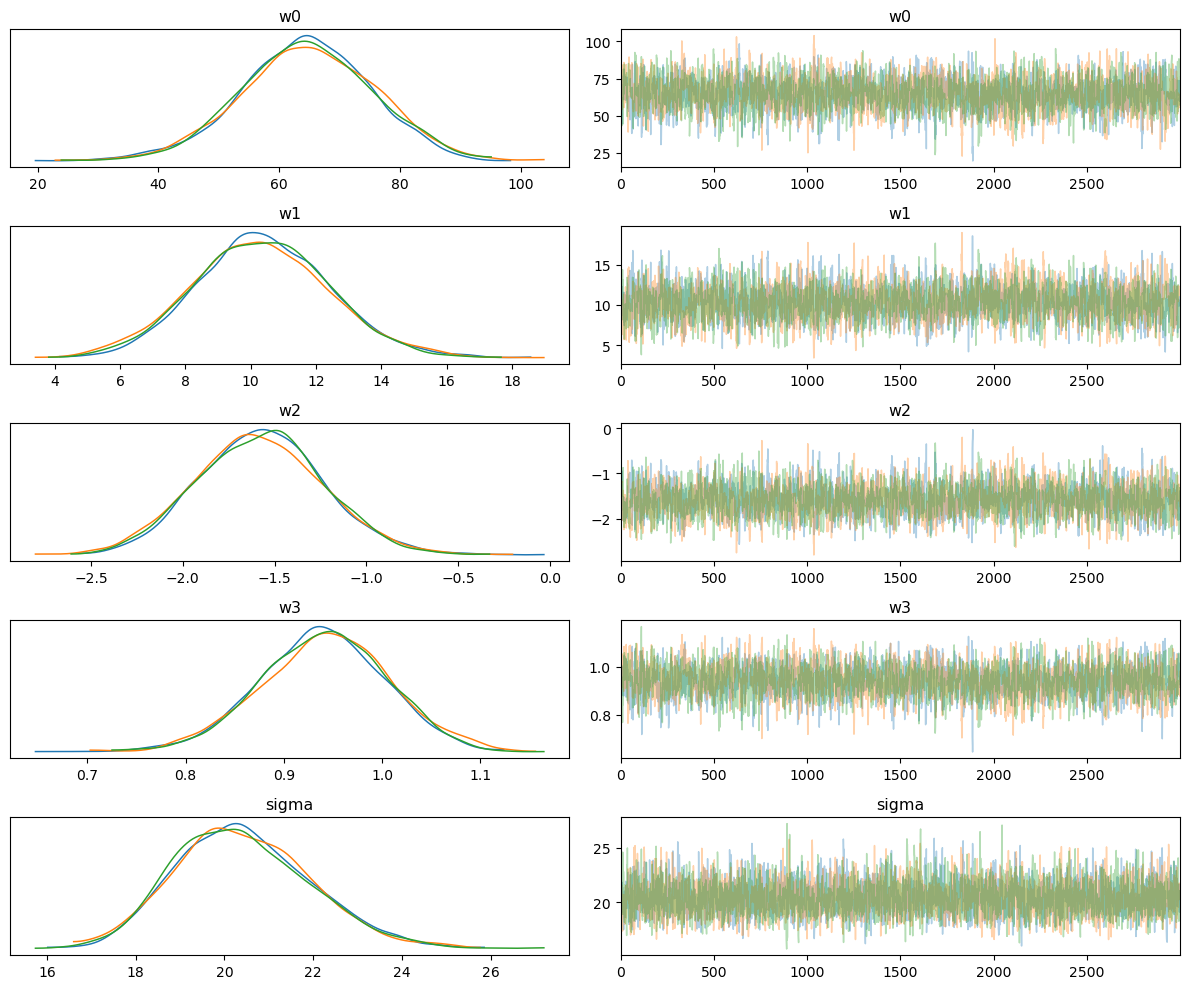

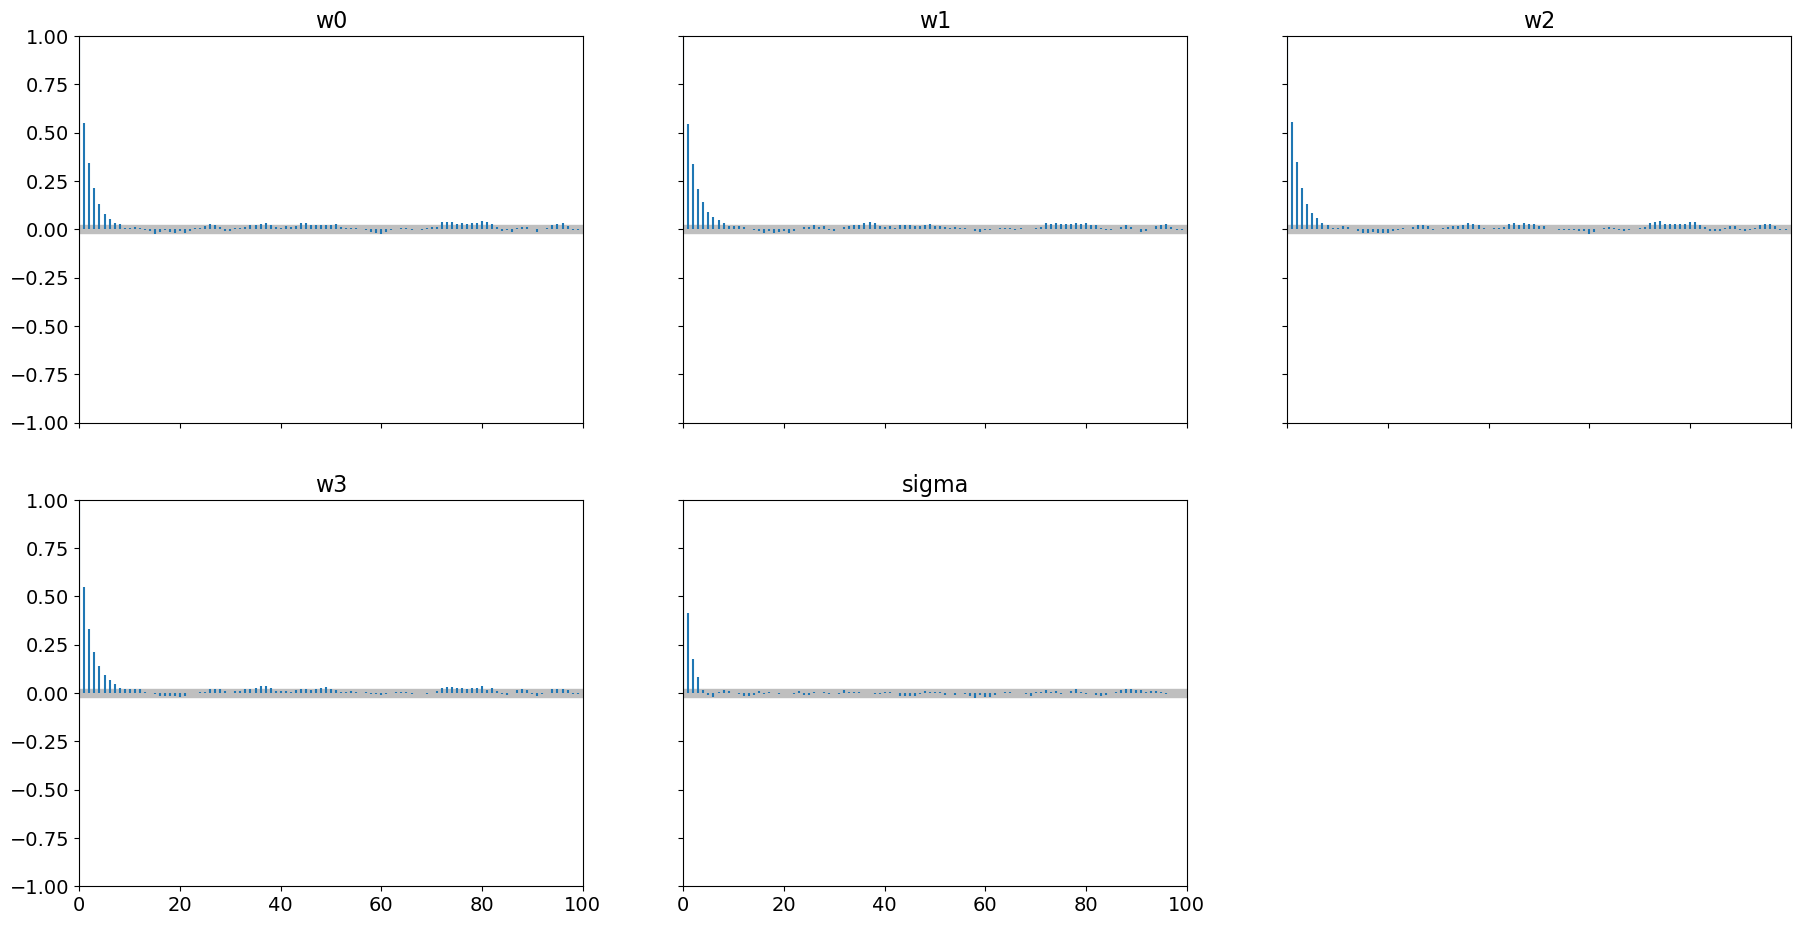

In [230]:
summary = az.summary(trace, var_names=["w0", "w1", "w2", "w3", "sigma"])
display(summary)

az.plot_trace(trace, var_names=["w0", "w1", "w2", "w3", "sigma"], compact=False)
plt.tight_layout()

az.plot_autocorr(trace, var_names=["w0", "w1", "w2", "w3", "sigma"], combined=True)
plt.show()

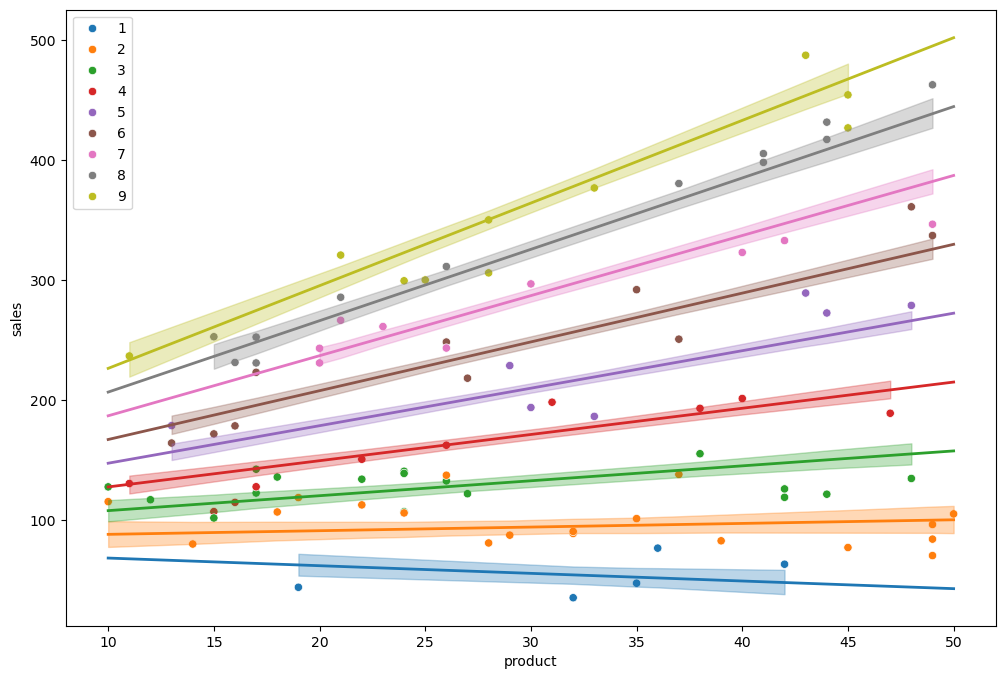

In [260]:
product_values = np.array([product.min(), product.max()]).reshape(1,-1)
clerks = np.unique(clerk).reshape(1,-1)
cmap = plt.get_cmap("tab10")

# 平均回帰直線の計算
# 行列計算については店員数ベクトル(9,1)と製品種類数の最小値と最大値のベクトル(1,2)の積を取ることで(9,2)の行列になる。この行列は各行が各回帰係数の左右端の値を持つ
w0_mean = summary['mean'].w0
w1_mean = summary['mean'].w1
w2_mean = summary['mean'].w2
w3_mean = summary['mean'].w3
means = w0_mean + w1_mean*clerks.T + (w2_mean + w3_mean*clerks).T @ product_values

# 95% HDIの計算
hdis = az.hdi(trace.posterior, hdi_prob=0.95)["mu"].values

# 各店員数ごとに回帰直線と95% HDIを描画
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
sns.scatterplot(x="product", y="sales", data=sales, hue="clerk", ax=axes, palette="tab10")
for i in clerks.reshape(-1):
    clerk_product = product[clerk==i]
    idx_clerk = np.argsort(clerk_product)
    hdi_clerk = hdis[clerk==i][idx_clerk]
    axes.plot(product_values.reshape(-1), means[i-1], lw=2, c=cmap(i-1))
    axes.fill_between(clerk_product[idx_clerk], y1=hdi_clerk[:,0], y2=hdi_clerk[:,1], color=cmap(i-1), alpha=0.30)
plt.legend()
plt.show()

この図から店員数が増えると製品の種類についての傾きが大きくなることがわかる。

### pystanでの実装

In [105]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import stan
import nest_asyncio
nest_asyncio.apply()

In [106]:
sales = pd.read_csv('../data/2-6-interaction-3.csv')

In [110]:
sales.sort_values(["clerk", "product"], inplace=True)
sales

,sales,product,clerk
68,44.2,19,1
10,35.5,32,1
62,47.6,35,1
20,76.8,36,1
32,63.4,42,1
...,...,...,...
67,306.0,28,9
2,376.7,33,9
22,487.2,43,9
33,426.7,45,9


In [113]:
y = sales["sales"].values
product = sales["product"].values
clerk = sales["clerk"].values
interaction = product * clerk
X = np.vstack([np.ones(len(y)), product, clerk, interaction]).T

In [122]:
product_pred = np.tile(np.linspace(product.min(), product.max(), 100), 9)
clerk_pred = np.tile(np.unique(clerk), (100, 1)).T.reshape(-1)
interaction_pred = product_pred * clerk_pred
X_pred = np.vstack([np.ones(900), product_pred, clerk_pred, interaction_pred]).T

In [123]:
stan_data = {
    "N": len(y),
    "K": X.shape[1],
    "y": y,
    "X": X,
    "N_pred": X_pred.shape[0],
    "X_pred": X_pred
}

In [124]:
with open('../stan/2-6-interaction.stan') as f:
    stan_code = f.read()

In [125]:
sm = stan.build(stan_code, data=stan_data, random_seed=123)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [126]:
fit = sm.sample(num_chains=3, num_samples=6000, num_warmup=1000, num_thin=2)

Sampling:   0%
Sampling:  33% (7000/21000)
Sampling:  67% (14000/21000)
Sampling: 100% (21000/21000)
Sampling: 100% (21000/21000), done.
Messages received during sampling:
  Gradient evaluation took 3.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.43 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.41 seconds.
  Adjust your expectations accordingly!


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],88.683,12.125,65.913,111.569,0.200,0.142,3683.0,4525.0,1.0
beta[1],-2.273,0.373,-2.967,-1.571,0.006,0.004,3645.0,4574.0,1.0
beta[2],6.374,2.225,2.075,10.474,0.036,0.025,3830.0,4632.0,1.0
beta[3],1.055,0.069,0.929,1.185,0.001,0.001,3788.0,5133.0,1.0
sigma,20.189,1.479,17.400,22.895,0.020,0.014,5738.0,6435.0,1.0


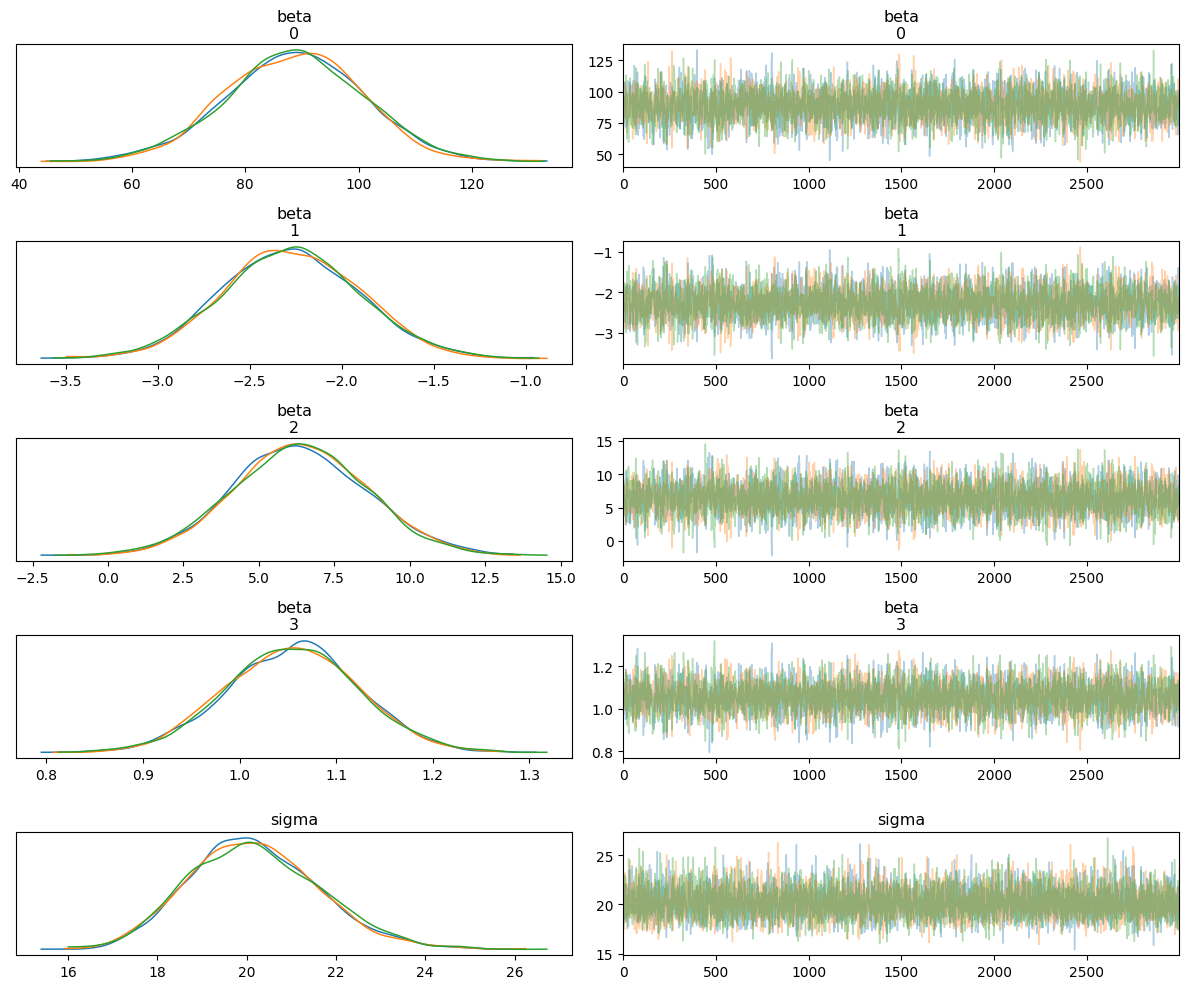

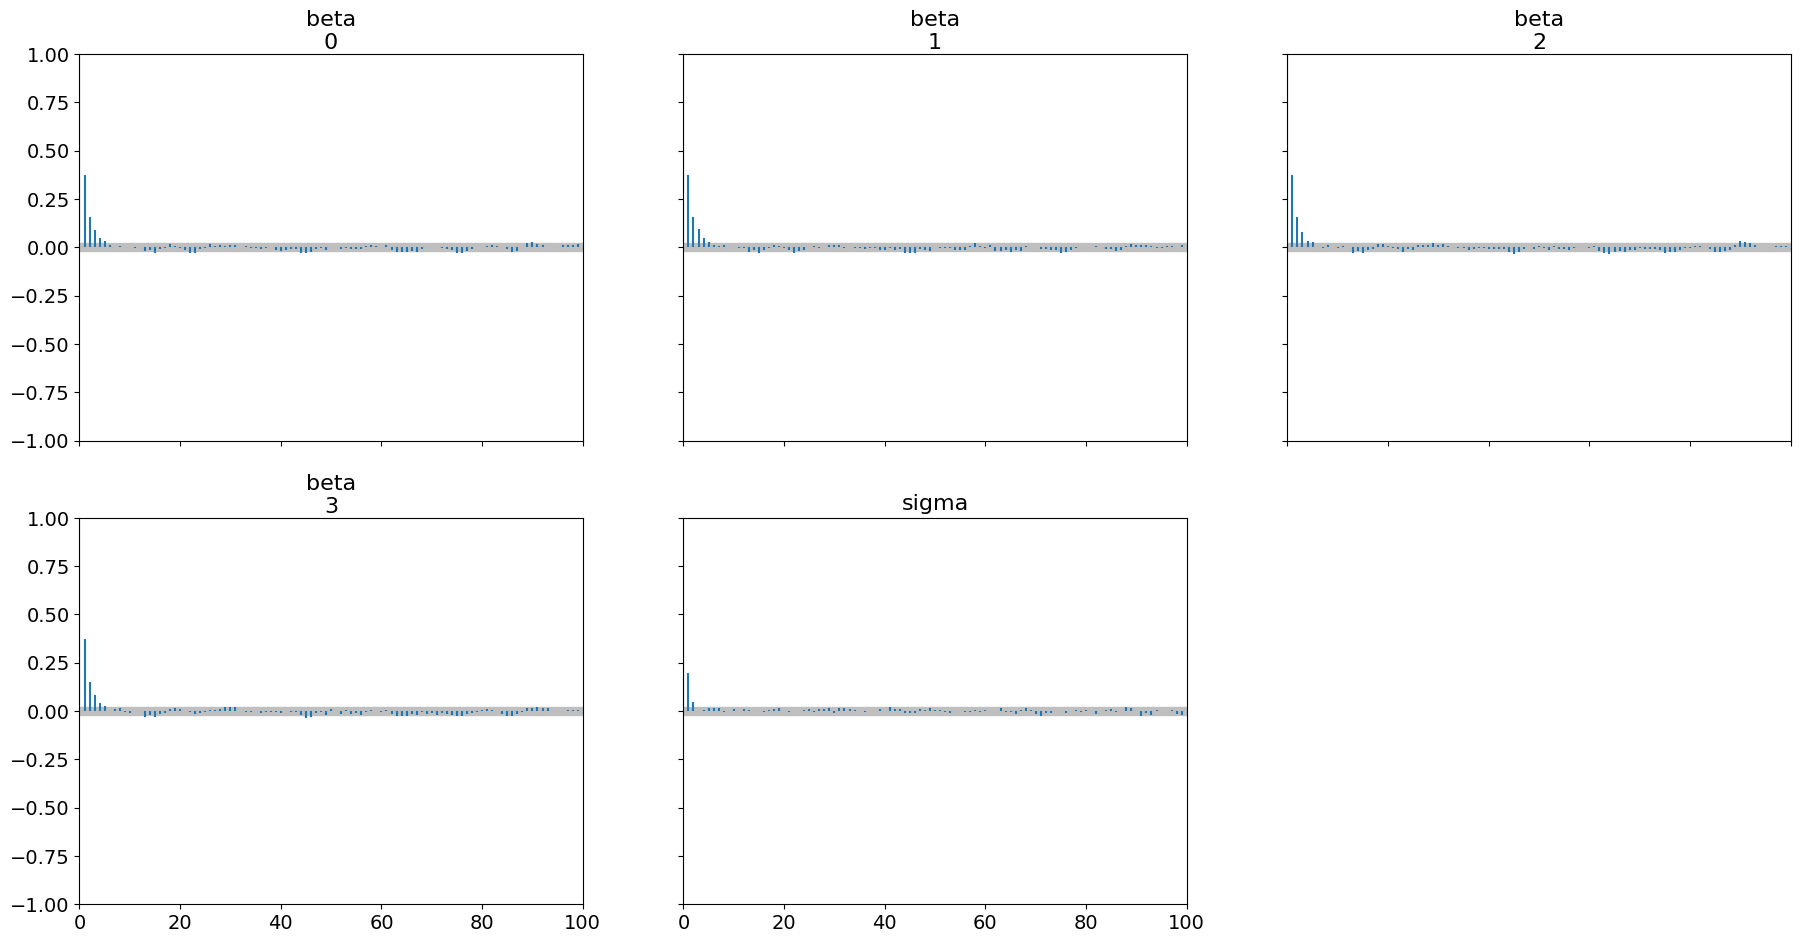

In [128]:
summary = az.summary(fit, var_names=["beta", "sigma"])
display(summary)

az.plot_trace(fit, var_names=["beta", "sigma"], compact=False)
plt.tight_layout()

az.plot_autocorr(fit, var_names=["beta", "sigma"], combined=True)
plt.show()

In [ ]:
product_pred = np.tile(np.linspace(product.min(), product.max(), 100), 9)
clerk_pred = np.tile(np.unique(clerk), (100, 1)).T.reshape(-1)
interaction_pred = product_pred * clerk_pred
X_pred = np.vstack([np.ones(900), product_pred, clerk_pred, interaction_pred]).T

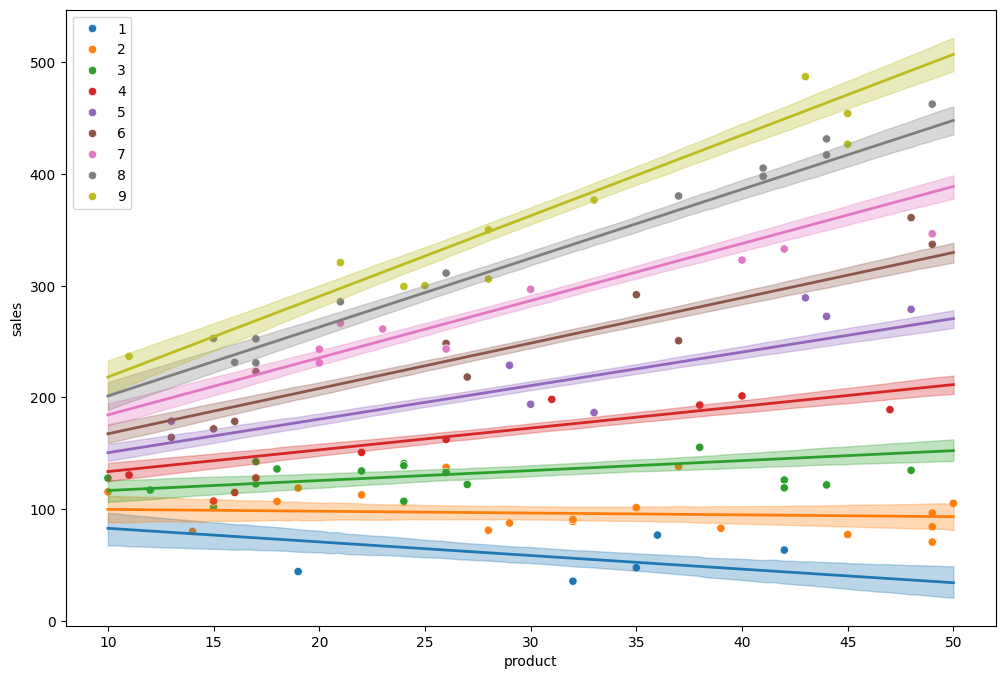

In [138]:
clerks = np.unique(clerk)
cmap = plt.get_cmap("tab10")

# 平均回帰直線の計算
# 行列計算については店員数ベクトル(9,1)と製品種類数の最小値と最大値のベクトル(1,2)の積を取ることで(9,2)の行列になる。この行列は各行が各回帰係数の左右端の値を持つ
beta_mean = az.summary(fit, var_names=["beta"])["mean"].values
means = np.dot(X_pred, beta_mean)

# 95% HDIの計算
hdis = az.hdi(fit, hdi_prob=0.95)["mu_pred"].values

# 各店員数ごとに回帰直線と95% HDIを描画
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
sns.scatterplot(x="product", y="sales", data=sales, hue="clerk", ax=axes, palette="tab10")
for i in clerks:
    clerk_idx = clerk_pred==i
    clerk_product = product_pred[clerk_idx]
    hdi_clerk = hdis[clerk_idx]
    reg_clerk = means[clerk_idx]
    axes.plot(clerk_product, reg_clerk, lw=2, c=cmap(i-1))
    axes.fill_between(clerk_product, y1=hdi_clerk[:,0], y2=hdi_clerk[:,1], color=cmap(i-1), alpha=0.30)
plt.legend()
plt.show()

### 係数の解釈
切片, 店員数の主効果, 製品数の主効果, 交互作用の期待値はそれぞれ64.5, 10.3, -1.5, 0.94である。主効果だけ見れば店員数が増え、製品の種類を減らせば売上は伸びそうであるが、交互作用を考えると$\mu_i$は次のようになる
$$
\mu_i = w_0 + w_1x_{1i} + (w_2 + w_3x_{1i})x_{2i} \\
\mu_i = 64.5 + 10.3x_{1i} + (-1.5 + 0.94x_{1i})x_{2i}
$$
よって店員数を増やすと製品の種類についての傾きは大きくなるので、店員がたくさんいる時は、製品の種類を増やした方が売上が伸びる。